In [3]:
import os
from glob import glob
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read the true and false files

228
255
../../ilab/ProstateX-Screenshots-Train/ProstateX-0000-Finding1-ep2d_diff_tra_DYNDIST_ADC0.bmp
(42, 42)


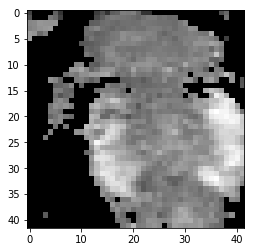

In [4]:
# Change to your own corresponding file path

ADC_PATH='../../ilab/ProstateX-Screenshots-Train/'
csv_file='../../ilab/ProstateX-Findings-Train.csv'
true_files=[]
false_files=[]




csvFile = open(csv_file, "r")
reader = csv.reader(csvFile)

for item in reader:
    if reader.line_num == 1:
        continue
    pre_name=item[0]+'-Finding'+item[1]
    if item[-1]=='TRUE':
        true_file=glob(ADC_PATH+pre_name+'*_ADC0.bmp')
#         print (true_file)
        for tfile in true_file:
            true_files.append(tfile)
    else:
        false_file=glob(ADC_PATH+pre_name+'*_ADC0.bmp')
#         print (false_file)
        for ffile in false_file:
            false_files.append(ffile)
            

# Since the size of the true data is small, we repeat the true fiels three times.
true_files=true_files*3
        
print (len(true_files))
print (len(false_files))

print (true_files[0])
img=cv2.imread(true_files[0],0)
print (img.shape)
plt.imshow(img,cmap=plt.cm.gray)
plt.show()

## Generate the network input data

(228, 64, 64, 3)
(255, 64, 64, 3)


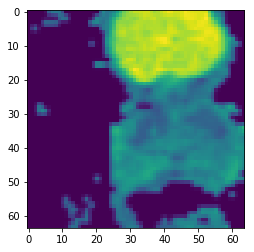

In [5]:
pixel_size=64
true_data=np.zeros((len(true_files),pixel_size,pixel_size,3))
false_data=np.zeros((len(false_files),pixel_size,pixel_size,3))



for t in range(len(true_files)):
    true_data[t,...,0]=cv2.resize(cv2.imread(true_files[t],0),(pixel_size,pixel_size))
    true_data[t,...,1]=cv2.resize(cv2.imread(true_files[t],0),(pixel_size,pixel_size))
    true_data[t,...,2]=cv2.resize(cv2.imread(true_files[t],0),(pixel_size,pixel_size))
for f in range(len(false_files)):
    false_data[f,...,0]=cv2.resize(cv2.imread(false_files[f],0),(pixel_size,pixel_size))
    false_data[f,...,1]=cv2.resize(cv2.imread(false_files[f],0),(pixel_size,pixel_size))
    false_data[f,...,2]=cv2.resize(cv2.imread(false_files[f],0),(pixel_size,pixel_size))


    
print (true_data.shape)
print (false_data.shape)

plt.imshow(true_data[20,:,:,0])
plt.show()

## Design the network

In [6]:
import gzip,pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (Activation, Convolution2D, Dense, Dropout, Flatten,
                          MaxPooling2D,normalization)
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import os,sys
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (Activation, Convolution2D, Dense, Dropout, Flatten,
                          MaxPooling2D,normalization,Cropping2D,Conv2D,Cropping2D,GlobalAveragePooling2D)
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import os
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers.convolutional import (
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    ZeroPadding2D
    
)
from keras import backend as K
from keras.callbacks import TensorBoard

from keras.models import Model
from keras.layers import Input, Dense, merge,BatchNormalization,UpSampling2D
from keras import optimizers

from scipy import misc
from glob import glob
import shutil,random
import keras
from keras.layers.merge import add,concatenate,multiply,average,maximum

from keras.layers import Input,Dense,UpSampling2D,ZeroPadding2D
from keras.models import Model

Using TensorFlow backend.


In [7]:
data=np.vstack((true_data,false_data))

true_label=[[0,1]]
false_label=[[1,0]]
label=np.array(true_label*len(true_data)+false_label*len(false_data))



def unison_shuffled_copies(a, b,rl):
    assert len(a) == len(b)
    r=range(len(a))
    random.shuffle(r,lambda:rl)
    p=np.array(r)
    #p = np.random.permutation(len(a))
    return a[p], b[p]

data,label=unison_shuffled_copies(data,label,0.2)

splitpoint = int(round(len(data) * 0.8))
(x_train, x_val) = (data[0:splitpoint], data[splitpoint:])
(y_train, y_val) = (label[0:splitpoint], label[splitpoint:])

print (x_train.shape)
print (x_val.shape)

(386, 64, 64, 3)
(97, 64, 64, 3)


In [8]:
input_1=Input(shape=(pixel_size,pixel_size,3))
conv_1=Conv2D(64,(3,3),activation='relu')(input_1)
max_1=MaxPooling2D((2,2))(conv_1)

conv_2=Conv2D(64,(3,3),activation='relu')(max_1)
max_2=MaxPooling2D((2,2))(conv_2)

conv_3=Conv2D(64,(3,3),activation='relu')(max_2)
max_3=MaxPooling2D((2,2))(conv_3)

conv_4=Conv2D(64,(3,3),activation='relu')(max_3)
max_4=MaxPooling2D((2,2))(conv_4)

# conv_5=Conv2D(64,(3,3),activation='relu')(max_4)
# max_5=MaxPooling2D((2,2))(conv_5)

Dense_1=Dense(128)(max_4)
Dense_1=Dropout(0.3)(Dense_1)
flatten_concat=Flatten()(Dense_1)
Dense_2=Dense(2,activation='softmax')(flatten_concat)

re_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                patience=5,  mode='auto')
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

model = Model(inputs=input_1, outputs=Dense_2)

model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=20,epochs=100,
         validation_data=(x_val,y_val),
         callbacks=[re_lr,early_stopper])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

## Heatmap Generation Process
Reference : http://www.hackevolve.com/where-cnn-is-looking-grad-cam/

In [9]:
# reference: http://www.hackevolve.com/where-cnn-is-looking-grad-cam/

x=x_val[:1,...]
preds=model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]

last_conv_layer = model.get_layer(index=-5)

grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [10]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(64, 64, 3)
(64, 64, 3)


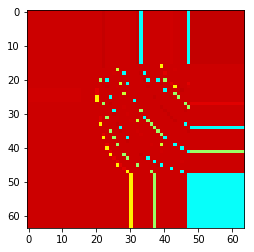

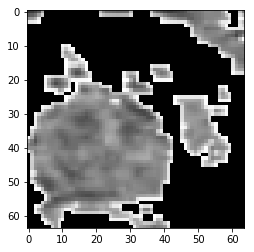

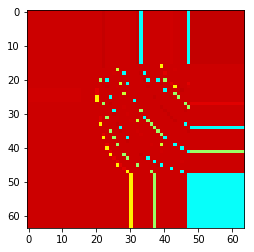

In [31]:
print (x[0].shape)
heatmap = cv2.resize(heatmap, (pixel_size, pixel_size))
print (heatmap.shape)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


####************Here need to improve****############
plt.imshow(heatmap)
plt.show()

plt.imshow(np.uint8(x[0]*255))
plt.show()

superimposed_img = cv2.addWeighted(np.uint8(x[0]), 0.6, heatmap, 0.4, 0)
plt.imshow(heatmap)
plt.show()
####************Here need to improve****############
